# Binary semantic segmentation. Applied Machine Learning project (10 cfu).
### Roberto Lepore, Master's Degree Bioinformatics.


**Semantic segmentation** aims to assign a class to each pixel in an image according to the semantic class of the object present in that point. The binary version of this problem consists in separating objects belonging to a single class, such as people, cats or cars, from the backgroud of the scene. However, semantic segmentation does not assign unique labels to different objects of the same class, which is instead done in instance segmentation. Therefore, the output of a binary semantic segmentation algorithm is a binary mask in which pixels belonging to a target object are labelled with the positive class.
Image segmentation is applied in many fields, such as medical imaging, intelligent video surveillance and autonomous cars.

In this project, I will implement a **simple MLP** as a baseline to be compared to a more apt **fully-convolutional encoder-decoder network**, inspired by **U-Net**[1].


1.Ronneberger O, Fischer P, Brox T (2015). "U-Net: Convolutional Networks for Biomedical Image Segmentation". arXiv:[1505.04597](https://arxiv.org/abs/1505.04597).

## Importing necessary modules

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import numpy as np
import json
# For interactive qualitative evaluation
import ipywidgets as widgets
from IPython.display import display

## Download dataset

The dataset I'm using is the [The Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/).
From the website:


> We have created a 37 category pet dataset with roughly 200 images for each class. The images have a large variations in scale, pose and lighting. All images have an associated ground truth annotation of breed, head ROI, and pixel level trimap segmentation.

For my goal, I'm considering all pets as belonging the same category (*foregound*) and the only things I need are the input images and the corresponding pixel level segmentations.

In [2]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2024-11-25 13:33:50--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2024-11-25 13:33:50--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/pets/images.tar.gz [following]
--2024-11-25 13:33:51--  https://thor.robots.ox.ac.uk/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [app

## Utility classes

Here I defined two classes relative to the processing and storing of images that are then used in training and testing the models.

The `ImageProcessor` class is a completely static class that contains the logic to preprocess input and target images, and postprocess the output of a model.
In particular:
* `preprocess_input` resizes the input image according to the model input size and normalizes the pixels values.
* `preprocess_target` resizes the target image to match the model input size, and sets backgroud pixels to 0 and foregroud pixels to 1.
* `postprocess_output` resizes the binary mask outputted from a model to match the input image size.



In [3]:
class ImageProcessor:
  @staticmethod
  def preprocess_input(img: np.ndarray, size: tuple[int,int]):
    # Input images must have 3 channels
    if len(img.shape) == 2:
        img = tf.image.grayscale_to_rgb(tf.expand_dims(img, axis=-1))
    elif img.shape[-1] == 4:
        img = img[..., :3]
    img = tf.image.resize(img, size)
    img = img / 255.0
    return img

  @staticmethod
  def preprocess_target(img: np.ndarray, size: tuple[int,int]):
    # Add channel dimension to use tf.image
    if len(img.shape) == 2:
        img = tf.expand_dims(img, axis=-1)
    img = tf.image.resize(img, size, method="nearest")
    # Map the values to 0 (background) or 1 (foreground)
    img = tf.where(
        (img == 0.007843137718737125 ), 0,
        tf.where(
            (img == 0.003921568859368563) | (img == 0.0117647061124444), 1, img
        )
    )
    return img

  @staticmethod
  def postprocess_output(img: np.ndarray, size: tuple[int,int]):
    return tf.image.resize(img, size, method='nearest')


I implemented the `ImageDataset` class to maintain the processed images and the training and testing subsets. All the models share the same `ImageDataset` object, in this way there is no duplication of data and the processing is done only once during the development. The first two lines inside the constructor are adapted from [this kaggle notebook](https://www.kaggle.com/code/abdalruhmanmohamed/oxford-segmentation/notebook).

In [4]:
class ImageDataset:
  """ Class that contains the dataset of images to be used during the training and evaluation of the models.
  It contains raw and preprocessed images, as well as training and testing subsets. """

  def __init__(self, with_cache = True):
    self.input_img_paths = np.array(sorted([os.path.join("images/" , fname )for fname in os.listdir("images/") if fname.endswith(".jpg")]))
    self.target_img_paths = np.array(sorted([os.path.join("annotations/trimaps/" , fname) for fname in os.listdir("annotations/trimaps/") if fname.endswith(".png") and not fname.startswith(".")]))
    # shuffle the images
    np.random.seed(42)
    indices = np.random.permutation(len(self.input_img_paths))
    self.input_img_paths = self.input_img_paths[indices]
    self.target_img_paths = self.target_img_paths[indices]

    self.input_processed = None
    self.target_processed = None
    self.processed_image_size = (None, None)
    self.train_data = None
    self.test_data = None
    self.with_cache = with_cache
    self.cache = {}


  def get_image(self, path: str) -> np.ndarray:
    """ Returns the image data as a numpy array."""
    return mpimg.imread(path)

  def get_input_image(self, index: int) -> np.ndarray:
    """ Returns the raw input image at the specified index as a numpy array."""
    return self.get_image(self.input_img_paths[index])

  def get_target_image(self, index: int) -> np.ndarray:
    """ Returns the raw target image at the specified index as a numpy array."""
    return self.get_image(self.target_img_paths[index])

  def size(self) -> tuple[int, int]:
    """ Returns a tuple containing the number of images in the input and target set, respectively."""
    return len(self.input_img_paths), len(self.target_img_paths)

  def preprocess_input_images(self, size: tuple[int, int]) -> None:
    """ Preprocesses the input images and stores them in self.input_processed."""
    self.input_processed = tf.stack([ImageProcessor.preprocess_input(self.get_image(path), size) for path in self.input_img_paths])

  def preprocess_target_images(self, size: tuple[int, int]) -> None:
    """ Preprocesses the target images and stores them in self.target_processed."""
    self.target_processed = tf.stack([ImageProcessor.preprocess_target(self.get_image(path), size) for path in self.target_img_paths])

  def preprocess(self, size: tuple[int, int]) -> None:
    """ Preprocesses the input and target images and stores them in self.input_processed and self.target_processed, respectively."""
    if self.processed_image_size == size: return
    if self.with_cache and self.cache.get(size) is not None: # Load from cache
      if self.cache.get(self.processed_image_size) is None: # Save previous in cache
        self.cache[self.processed_image_size] = (self.input_processed, self.target_processed)
      self.input_processed, self.target_processed = self.cache[size]
      self.processed_image_size = size
      self.train_data = self.test_data = None
    else: # New size
      if self.with_cache and self.processed_image_size != (None,None): # Save previous in cache
        self.cache[self.processed_image_size] = (self.input_processed, self.target_processed)
      self.processed_image_size = size
      self.preprocess_input_images(size)
      self.preprocess_target_images(size)
      self.train_data = self.test_data = None

  def split(self, split: float) -> None:
    """ Splits the dataset into training and testing subsets and stores them in self.train_data and self.test_data, respectively."""
    split_idx = int(len(self.input_processed) * split)
    self.train_data = (self.input_processed[:split_idx], self.target_processed[:split_idx])
    self.test_data = (self.input_processed[split_idx:], self.target_processed[split_idx:])

  def get_train_test_split(self, split = 0.8) -> None:
    """ Returns the training and testing subsets of the dataset. """
    if self.train_data is None:
      self.split(split)
    return self.train_data, self.test_data

In [5]:
image_ds = ImageDataset()

The `Metrics` class is a static class that implements scoring metrics for image segmentation, namely intersection over union and dice coefficient.

Reference: [Understanding Evaluation Metrics in Medical Image Segmentation](https://medium.com/@nghihuynh_37300/understanding-evaluation-metrics-in-medical-image-segmentation-d289a373a3f)

In [6]:
class Metrics:
  """ Utility class containing evalutation metrics for the image segmentation problem.

  Attributes:
    metrics_map: Mapping of the string name of the metrics to their actual function.
  """

  @staticmethod
  def precision(y_true, y_pred, threshold=0.5) -> float:
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    total_pred = tf.reduce_sum(y_pred)
    return intersection / total_pred

  @staticmethod
  def recall(y_true, y_pred, threshold=0.5) -> float:
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    total_true = tf.reduce_sum(y_true)
    return intersection / total_true if total_true != 0 else 1

  @staticmethod
  def iou(y_true, y_pred, threshold=0.5) -> float:
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / union


  @staticmethod
  def pixel_acc(y_true, y_pred, threshold=0.5) -> float:
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    xor = tf.reduce_sum(tf.cast(tf.equal(y_pred, y_true) ,tf.float32))
    return xor / (union+xor-intersection)

  @staticmethod
  def dice(y_true, y_pred, threshold=0.5) -> float:
    """ Static method implementing the Dice similarity coefficient """
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    total = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return 2*intersection / total

  metrics_map = {
    "precision": precision,
    "recall": recall,
    "pixel_accuracy": pixel_acc,
    "iou": iou,
    "dice": dice,
    "accuracy": "accuracy"
  }

  @staticmethod
  def get_metric(metric_name: str):
    """ Returns the function corresponding to the given metric name. """
    return Metrics.metrics_map[metric_name]

  @staticmethod
  def get_metrics(metrics: list[str]):
    """ Returns a list of functions corresponding to the given metric names. """
    return [Metrics.get_metric(metric) for metric in metrics]

## Models setup

Model configuration files are a useful way to easily setup and tweak the hyperparameters of a model during development. For this reason I implemented the `Config` class following the instructions in the book "**Deep learning in production**" ([github repo here](https://github.com/The-AI-Summer/Deep-Learning-In-Production)).

In [7]:
class Config:
  """Configuration class that contains train and model hyperparameters"""

  def __init__(self, train, model) -> None:
    self.train = train
    self.model = model

  @classmethod
  def from_json(cls, cfg) -> "Config":
    params = json.loads(json.dumps(cfg), object_hook=HelperObject)
    return cls(params.train, params.model)

class HelperObject(object):
    """Helper class to convert json into Python object"""
    def __init__(self, dict_):
        self.__dict__.update(dict_)

`BaseModel` is the base class that all models extends. The only method each subclass must define is the `build` method.





In [8]:
class BaseModel:
  """Base class for all models"""

  def __init__(self, config: dict) -> None:
    self.config = Config.from_json(config)
    self.model = None
    self.train_data = None
    self.test_data = None

  def load_data(self, dataset: ImageDataset) -> None:
    """ Loads the images in the dataset in the model. """
    dataset.preprocess(size = tuple(self.config.model.input[:2]))
    self.train_data, self.test_data = dataset.get_train_test_split(split = self.config.train.split)

  def build(self) -> None:
    """ Base method to be overridden. """
    pass

  def train(self) -> None:
    """ Starts the training of the model. """
    x_train, y_train = self.train_data
    history = self.model.fit(
        x_train,
        y_train,
        epochs=self.config.train.epochs,
        batch_size=self.config.train.batch_size,
        validation_split=self.config.train.validation_split
    )
    return history

  def evaluate(self):
    """ Evaluates the model on the test set. """
    x_test, y_test = self.test_data
    return self.model.evaluate(x_test, y_test, return_dict=True)

  def predict(self, input_image, to_process = False) -> np.ndarray:
    """ Predicts the segmentation mask for the given input image. """
    if to_process:
      input_image = ImageProcessor.preprocess_input(input_image, tuple(self.config.model.input[:2]))
    input_image = tf.expand_dims(input_image, axis=0) # Add batch dimension
    return self.model.predict(input_image)

  def save_model_and_history(self, history: tf.keras.callbacks.History):
    """ Saves the model weights and the training history to files. """
    with open(f"history_{self.config.model.name}.json", 'w') as fw:
      json.dump(history.history, fw)
    self.model.save_weights(f"{self.config.model.name}.weights.h5")

  def load_model_and_history(self) -> tf.keras.callbacks.History:
    """ Loads the model weights and the training history from files. """
    self.model.load_weights(f"{self.config.model.name}.weights.h5")
    history = tf.keras.callbacks.History()
    with open(f"history_{self.config.model.name}.json", 'r') as fr:
      history.history = json.load(fr)
    return history

## MLP
The baseline model is a simple MLP adapted for the segmentation task. The input image is flattened, then a series of fully-connected layers with a decreasing number of neurons perform feature extraction. After each layer, dropout is applied to prevent overfitting. The last layer predicts a class probability for each pixel which are then reshaped to match the desired output.
Obviously, the feature extraction is not spacially aware, and therefore the model won't be able to accurately identify the objects.

In [19]:
class SegmentationMLP(BaseModel):
  def __init__(self, config) -> None:
    super().__init__(config)

  def build(self) -> None:
    """ Builds the MLP model. """
    input_shape = self.config.model.input
    output_shape = self.config.model.output

    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Flatten()(inputs)

    for size in self.config.model.layers:
      x = tf.keras.layers.Dense(size, activation='relu')(x)
      x = tf.keras.layers.Dropout(self.config.model.dropout)(x)

    x = tf.keras.layers.Dense(output_shape[0] * output_shape[1], activation='sigmoid')(x)
    outputs = tf.keras.layers.Reshape(output_shape)(x)

    self.model = tf.keras.Model(inputs, outputs)

    metrics = Metrics.get_metrics(self.config.train.metrics)
    self.model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=self.config.train.learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=metrics
    )


In [20]:
CFG_MLP = {
  "train": {
    "learning_rate": 0.001,
    "split": 0.8,
    "batch_size": 64,
    "epochs": 20,
    'validation_split': 0.1,
    "metrics": ["iou"]
  },

  "model": {
    "input": [128, 128, 3],
    "layers": [ 512, 256, 128],
    "output": [128, 128, 1],
    "dropout": 0.3,
    "name": "mlp"
  }
}

In [21]:
MLP_model = SegmentationMLP(CFG_MLP)
MLP_model.build()
MLP_model.model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 49152)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      25,166,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16384)               │       2,113,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 128, 128, 1)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,444,096 (104.69 MB)

 Trainable params: 27,444,096 (104.69 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
MLP_model.load_data(image_ds) # Usually takes a minute

Now that the images have been loaded and preprocessesed, we can compare the raw input and target images with their preprocessed counterparts to make sure the processing was performed right.

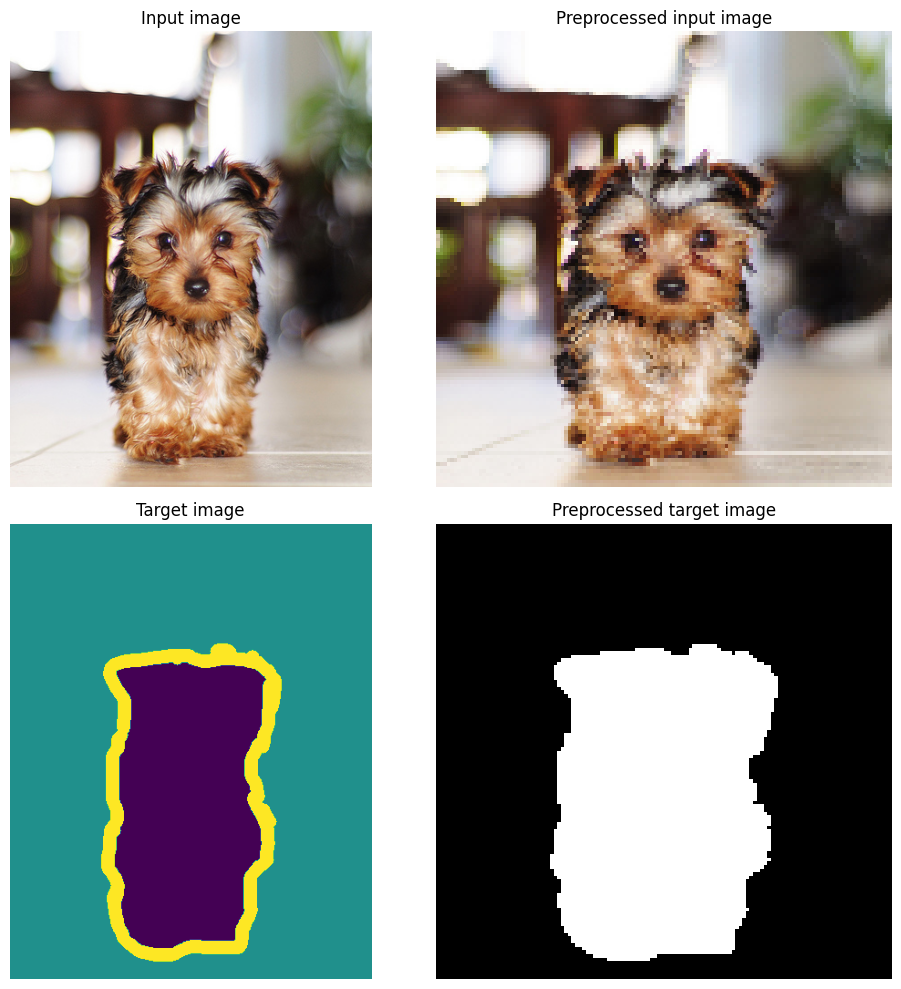

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].imshow(image_ds.get_input_image(0))
axes[0, 0].set_title("Input image")
axes[0, 0].axis('off')

axes[0, 1].imshow(image_ds.train_data[0][0].numpy())
axes[0, 1].set_title("Preprocessed input image")
axes[0, 1].axis('off')

axes[1, 0].imshow(image_ds.get_target_image(0))
axes[1, 0].set_title("Target image")
axes[1, 0].axis('off')

''' out_post = tf.expand_dims(image_ds.train_data[1][0].numpy(), axis=-1)
out_post = ImageProcessor.postprocess_output(out_post, (400, 600)) '''

axes[1, 1].imshow(image_ds.train_data[1][0], cmap="gray", vmin=0, vmax=1)
axes[1, 1].set_title("Preprocessed target image")
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
history_mlp = MLP_model.train()

Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - iou: 0.4771 - loss: 0.5629 - val_iou: 0.5051 - val_loss: 0.5367
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - iou: 0.5113 - loss: 0.5269 - val_iou: 0.5123 - val_loss: 0.5313
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - iou: 0.5129 - loss: 0.5253 - val_iou: 0.5070 - val_loss: 0.5254
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - iou: 0.5128 - loss: 0.5291 - val_iou: 0.5094 - val_loss: 0.5352
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - iou: 0.5096 - loss: 0.5218 - val_iou: 0.5116 - val_loss: 0.5285
Epoch 6/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - iou: 0.5087 - loss: 0.5204 - val_iou: 0.5079 - val_loss: 0.5262
Epoch 7/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - iou: 0.5118 - loss: 0.5220 - val_iou: 0.5068 - val_loss: 0.5163
Epoch 8/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - iou: 0.5122 - loss: 0.5168 - val_iou: 0.5128 - val_loss: 0.5206
Epoch 9/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - iou: 0.51

In [ ]:
#MLP_model.save_model_and_history(history_mlp)

In [ ]:
#!cp "/content/history_mlp.json" "/content/drive/MyDrive/Uni/binary_seg/history_mlp.json"
#!cp "/content/mlp.weights.h5" "/content/drive/MyDrive/Uni/binary_seg/mlp.weights.h5"

### Evaluation

First, we can plot the IoU and loss values through the training epochs. I adapted these functions from the [hands-on lecture on image classification](https://colab.research.google.com/drive/1qGIMz3vGPPpU5zdlWNa0l5yhpefIiSLb).

In [9]:
!cp /content/drive/MyDrive/Uni/binary_seg/* "/content/"

In [ ]:
history_mlp = MLP_model.load_model_and_history()

In [ ]:
def plot_compare(history):
    def smooth_curve(points, factor=0.8):
      smoothed = []
      for point in points:
          if smoothed:
              previous = smoothed[-1]
              smoothed.append(previous * factor + point * (1 - factor))
          else:
              smoothed.append(point)
      return smoothed

    iou = smooth_curve(history.history['iou'])
    val_iou = smooth_curve(history.history['val_iou'])
    loss = smooth_curve(history.history['loss'])
    val_loss = smooth_curve(history.history['val_loss'])

    plt.figure(figsize=(6, 4))
    plt.plot(loss, c='#0c7cba', label='Train Loss')
    plt.plot(val_loss, c='#0f9d58', label='Val Loss')
    plt.xticks(range(0, len(loss), 5))
    plt.xlim(0, len(loss))
    plt.title('Train Loss: %.3f, Val Loss: %.3f' % (loss[-1], val_loss[-1]), fontsize=12)
    plt.legend()

    plt.figure(figsize=(6, 4))
    plt.plot(iou, c='#0c7cba', label='Train IoU')
    plt.plot(val_iou, c='#0f9d58', label='Val IoU')
    plt.xticks(range(0, len(iou), 5))
    plt.xlim(0, len(iou))
    plt.title('Train IoU: %.3f, Val IoU: %.3f' % (iou[-1], val_iou[-1]), fontsize=12)
    plt.legend()

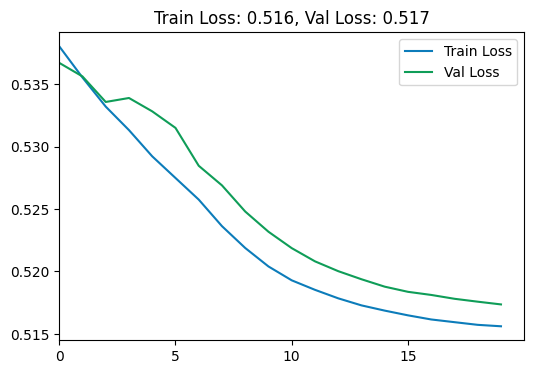

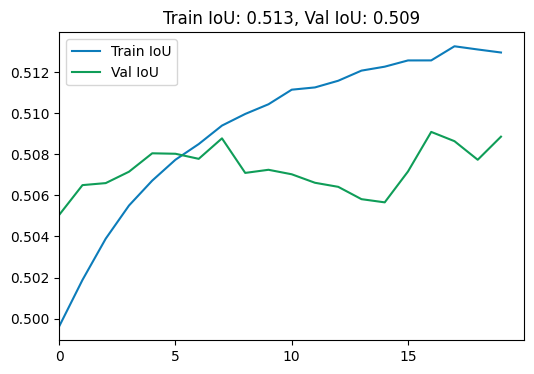

In [ ]:
plot_compare(history_mlp)

The first plot shows the training and validation loss across epochs. Both decrease steadily with a minimal gap between the two, indicating a good generalization power without overfitting.

The second plot tracks the Intersection over Union progress on the training and validation sets. The training IoU increases consistently and seems to reach a sort of plateau, while the validation IoU shows less improvement over time with some fluctuations.

Here I compute IoU, Dice coefficient, precision, recall, and pixel accuracy for each example in the testing set to visualize their distribution.

In [ ]:
def get_metrics(model):
  metrics = ["iou", "dice", "precision", "recall", "pixel_accuracy"]
  results = {m: [] for m in metrics}
  for i in range(len(image_ds.test_data[0][100])):
    prediction = model.predict(image_ds.test_data[0][i])
    y_true = image_ds.test_data[1][i]
    for name in metrics:
      results[name].append(Metrics.get_metric(name)(y_true, prediction))
  return results

In [ ]:
def plot_metrics(results):
  metrics = ["iou", "dice", "precision", "recall", "pixel_accuracy"]
  plt.figure(figsize=(10, 6))
  plt.boxplot([results[metric] for metric in metrics], labels=metrics)
  plt.xlabel('Metric')
  plt.grid(axis='y', linestyle='--', alpha=0.7)
  plt.show()

In [ ]:
%%capture
results = get_metrics(MLP_model)

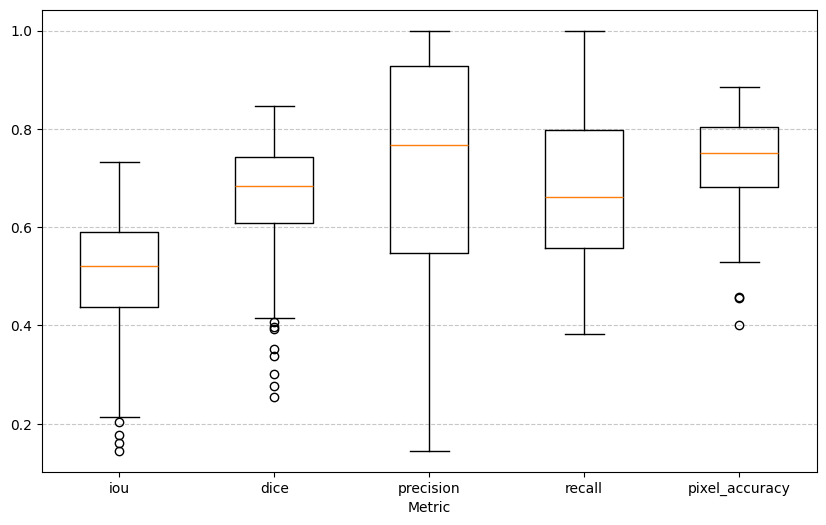

In [ ]:
plot_metrics(results)

Dice coefficient and pixel accuracy have a good median and quite narrow ranges. Precision has the highest median, and the gap with recall indicates that models tends to avoid false positives at the cost of missing many true positives.
The median IoU is not excellent, and probably fine-tuning some parameters could push it closer to 1.

### Qualitative evaluation

In order to have a more comprehensive analysis, I implemented two interactive widgets for the qualitative evaluation of the predictions. `mask_compare` displays the real and predicted masks side by side, making it easier to focus on the specific features of the predictions. `overlap_prediction` puts the predicted mask over the input image with some transparency to immediately understand how accurate the prediction is.  


In [ ]:
def mask_compare(images_input, images_target, model):
  def display_images(img_idx):
    input_image = images_input[img_idx].numpy()
    predicted_mask = MLP_model.predict(input_image)
    predicted_mask = tf.round(predicted_mask).numpy()
    true_mask = images_target[img_idx].numpy()

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(predicted_mask.squeeze(), cmap='gray')
    axes[0].set_title("Predicted Mask")
    axes[0].axis("off")

    axes[1].imshow(true_mask.squeeze(), cmap='gray')
    axes[1].set_title("True Mask")
    axes[1].axis("off")

    plt.show()

  slider = widgets.IntSlider(
      value=0,
      min=0,
      max=len(images_input) - 1,
      step=1,
      description="Image Index",
      continuous_update=False
  )

  return display_images, slider

In [16]:
def overlap_prediction(images, model):
  def overlap_prediction_int(img_idx, threshold):
    image = images[img_idx].numpy()
    prediction = model.predict(image)
    if threshold > 0:
      prediction = tf.cast(prediction > threshold, tf.float32)
      mask = prediction.numpy().squeeze()
      overlap = image.copy()
      light_green = np.array([0.5, 1.0, 0.5])
      overlap[mask == 1] = light_green
      al = 0.5
    else:
      overlap = prediction.squeeze()
      al = 0.8

    plt.imshow(image)
    plt.imshow(overlap, alpha=al, cmap='gray')
    plt.axis('off')
    plt.show()

  slider = widgets.IntSlider(
      value=0,
      min=0,
      max=len(images) - 1,
      step=1,
      description="Image Index",
      continuous_update=False
  )

  slider_th = widgets.FloatSlider(
      value=0.5,
      min=0,
      max=1,
      step=0.1,
      description="Threshold",
      continuous_update=False
  )

  return overlap_prediction_int, slider, slider_th


In [ ]:
callback, slider = mask_compare(MLP_model.test_data[0], MLP_model.test_data[1], MLP_model)
output = widgets.interactive_output(callback, {'img_idx': slider})
display(slider, output)

IntSlider(value=0, continuous_update=False, description='Image Index', max=1477)

Output()

In [ ]:
# Setting the threshold slider to 0 will show the confidence map!
callback, slider, slider_th = overlap_prediction(image_ds.test_data[0], MLP_model)
output = widgets.interactive_output(callback, {'img_idx': slider, "threshold": slider_th})
display(slider, slider_th, output)

IntSlider(value=0, continuous_update=False, description='Image Index', max=1477)

FloatSlider(value=0.5, continuous_update=False, description='Threshold', max=1.0)

Output()

The MLP seems to have learnt to identify the rough positioning of the objects. However, animals are usually in the middle of the pictures, so a more diverse dataset or artificially augmenting this dataset could push the model to better generalize the predictions. Furthermore, the MLP is far from accurate in predicting the actual shape of the animals, and the predicted masks are usually just blobs of pixels.

##Encoder-decoder Convolutional Network

The following model is a fully convolutional network with an encoder-decoder architecture. The first 3 pairs of convolutional and max-pooling layers make up the encoding section, which ends in the bottleneck consisting of a single convolutional layer. The segmentation map is then reconstructed in the decoding section, made up of 3 deconvolution layers. The last convolutional layer executes a 1x1 convolution with a single filter: it collapses the filter dimension and computes a probability value (sigmoid activation) for each pixel (1x1 kernel).


In [10]:
class CNNEncoderDecoder(BaseModel):
    def __init__(self, config):
        super().__init__(config)

    def build(self):
        input_shape = self.config.model.input

        inputs = tf.keras.Input(shape=input_shape)

        x = inputs
        encoder_filters = self.config.model.encoder_filters
        for filters in encoder_filters:
            x = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
            x = tf.keras.layers.MaxPooling2D((2, 2))(x)

        x = tf.keras.layers.Conv2D(self.config.model.bottleneck, (3, 3), activation='relu', padding='same')(x)

        decoder_filters = self.config.model.decoder_filters
        for filters in decoder_filters:
            x = tf.keras.layers.Conv2DTranspose(filters, (3, 3), activation='relu', strides=(2, 2), padding='same')(x)

        outputs = tf.keras.layers.Conv2D(
            filters=1,
            kernel_size=(1, 1),
            activation='sigmoid'
        )(x)

        self.model = tf.keras.Model(inputs, outputs)

        metrics = Metrics.get_metrics(self.config.train.metrics)
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=self.config.train.learning_rate),
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            metrics=metrics
        )

In [11]:
CFG_CNN = {
  "train": {
    "learning_rate": 0.001,
    "split": 0.8,
    "batch_size": 64,
    "epochs": 20,
    'validation_split': 0.1,
    "metrics": ["iou"]
  },

  "model": {
    "input": (128, 128, 3),
    "encoder_filters": [64, 128, 256],
    "bottleneck": 512,
    "decoder_filters": [256, 128, 64],
    "name": "cnn"
  }
}

In [12]:
CNN_model = CNNEncoderDecoder(CFG_CNN)
CNN_model.build()
CNN_model.model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 32, 32, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 64, 64, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 128, 128, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 1)         │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,099,777 (11.82 MB)

 Trainable params: 3,099,777 (11.82 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
CNN_model.load_data(image_ds)

In [ ]:
history_cnn = CNN_model.train()

Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 56s 394ms/step - iou: 0.1836 - loss: 0.6419 - val_iou: 0.5582 - val_loss: 0.5433
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 46s 207ms/step - iou: 0.5653 - loss: 0.4931 - val_iou: 0.5961 - val_loss: 0.4412
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 21s 212ms/step - iou: 0.6186 - loss: 0.4275 - val_iou: 0.6660 - val_loss: 0.3870
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 210ms/step - iou: 0.6491 - loss: 0.3938 - val_iou: 0.6199 - val_loss: 0.3990
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 18s 209ms/step - iou: 0.6662 - loss: 0.3742 - val_iou: 0.6901 - val_loss: 0.3469
Epoch 6/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 207ms/step - iou: 0.6969 - loss: 0.3400 - val_iou: 0.5353 - val_loss: 0.5161
Epoch 7/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 21s 210ms/step - iou: 0.6809 - loss: 0.3578 - val_iou: 0.7241 - val_loss: 0.3161
Epoch 8/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 18s 211ms/step - iou: 0.7288 - loss: 0.3090 - val_iou: 0.6950 - val_loss: 0.3285
Epoch 9/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 209ms/

In [ ]:
#CNN_model.save_model_and_history(history_cnn)

In [ ]:
#!cp "/content/history_cnn.json" "/content/drive/MyDrive/Uni/binary_seg/history_cnn.json"
#!cp "/content/cnn.weights.h5" "/content/drive/MyDrive/Uni/binary_seg/cnn.weights.h5"

### Evaluation
Here I follow the same evaluation procedure as I did for the MLP model.

In [14]:
history_cnn = CNN_model.load_model_and_history()

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


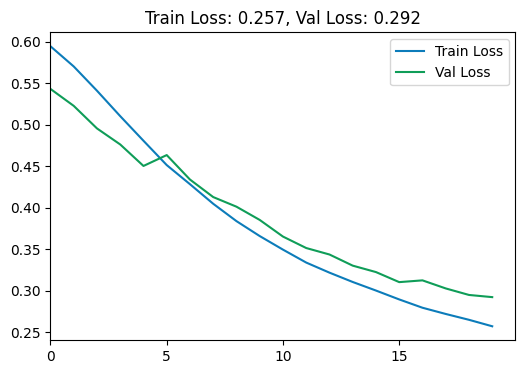

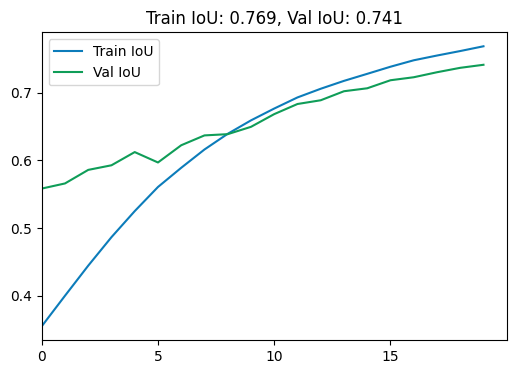

In [ ]:
plot_compare(history_cnn)

Compared to the MLP, the loss and IoU values are much better, as expected. The validation loss also decreases steadily, but slightly diverges from the training loss in last epochs. Possibly, training for a higher number of epochs would cause some overfitting. The final training IoU reaches 0.77. This demonstrates that a convolutional architecture is much more appropriate for the segmentation task.

In [ ]:
%%capture
results = get_metrics(CNN_model)

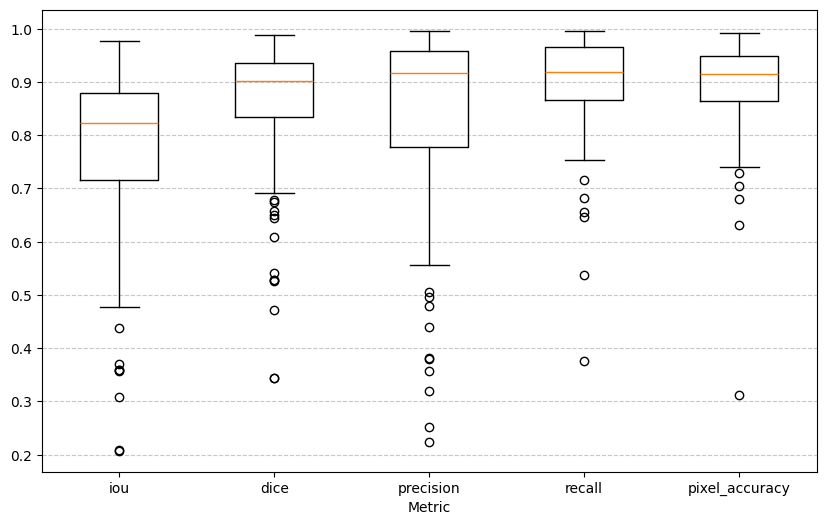

In [ ]:
plot_metrics(results)

All metrics except IoU reach a median above 0.9 in the testing set. In this case, precision and recall are well balanced indicating that the model is not too conservative nor liberal. All the metrics display some outliers, which tells us that the model still struggles with some of the more challenging examples.

### Qualitative evaluation

In [ ]:
callback, slider, slider_th = overlap_prediction(image_ds.test_data[0], CNN_model)
output = widgets.interactive_output(callback, {'img_idx': slider, "threshold": slider_th})
display(slider, slider_th, output)

IntSlider(value=0, continuous_update=False, description='Image Index', max=1477)

FloatSlider(value=0.5, continuous_update=False, description='Threshold', max=1.0)

Output()

In [17]:
callback, slider, slider_th = overlap_prediction(image_ds.test_data[0], CNN_model)
output = widgets.interactive_output(callback, {'img_idx': slider, "threshold": slider_th})
display(slider, slider_th, output)

IntSlider(value=0, continuous_update=False, description='Image Index', max=1477)

FloatSlider(value=0.5, continuous_update=False, description='Threshold', max=1.0)

Output()

The CNN has learnt to identify the correct position and shape of the animals in most cases. Particularly in pictures where the background is mostly plain, the shape is well delineated and the confidence map is much more defined than in the MLP predictions.

In [18]:
callback, slider, slider_th = overlap_prediction(image_ds.test_data[0], CNN_model)
output = widgets.interactive_output(callback, {'img_idx': slider, "threshold": slider_th})
display(slider, slider_th, output)

IntSlider(value=0, continuous_update=False, description='Image Index', max=1477)

FloatSlider(value=0.5, continuous_update=False, description='Threshold', max=1.0)

Output()

In cases as the one above, the segmentation presents some holes, and conversely some small pathes in the background appear. This problem could be marginalized by applying morphological operations to the output mask.

### Possible improvements
Although the results look promising, the architecture could be improved by adding **skip connections** between the encoder and the decoder (as it is done in UNet).

As already stated, the animals are mostly in the center of the pictures, so it could be useful to **augment the dataset** in order to push the models to  generalize better.
